In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import random
import time 
import os
import itertools 

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis

from pathlib import Path

dir_path = os.path.dirname(os.path.realpath("__file__"))

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# User-defined Functions: Observables/Quantities 

User-defined functions are stored in user_func.py and are used by data_manager.py to make datasets. 

A default function H_mapper(L, basis, x) is provided and generates the Hamiltonian (array) for a system of size L, in a given basis, for the parameters specified in the tuple x. The make_data() function in data_manager.py will repeatedly call this function over lists of parameter values. 

As a default, H_mapper constructs an example Hamiltonian for a XXZ spin chain model with a uniform z-field applied. The default parameters (alpha, beta, ...) here are consistent with the default parameters given to make_data(). This default is only an example, and is meant to be modified by the user to choose any model of interest. For consistency, the user must ensure that calls to make_data() in data_manager.py must have a parameter list of same length (or larger) compared to the number of parameters expected by H_mapper.

Template examples of different user-defined functions for several physical observables are given below. Return types must be 1D or 2D np.arrays() to write to text files (one may need to flatten higher-dimensional arrays). If a 0D np.array is needed, enclose the scalar value in a list [#] to satisfy np.savetxt() in make_data(). New user defined functions must include a "_func" at the end of their name to be properly identified by make_data(). They must also have the same input parameters \[e.g. (L,basis,x,H,E,V)\] across definitions - even if some of these parameters are not used; this enables make_data() to access them in a single loop. 

Some of the template examples use the quspin module to generate operators and matrix elements in an efficient matter. The templates below are easily adaptable for basic use with different physical systems and operators. For more sophisticated capabilities see the [quspin documentation](http://weinbe58.github.io/QuSpin/). 

### Hamiltonian Mapper

In [4]:
def H_mapper(L, basis, x):
    ''' 
    Make Hamiltonian for a system of size L in a specific basis, given a parameter tuple x.
    '''
    
    #print('x = ', x)
    
    # Try to assign parameters into a readable form
    try:
        alpha = x[0]
        beta = x[1]
        gamma = x[2]
        g = gamma*np.linspace(-0.5,0.5,L-1) #
        
    except ValueError: 
        print("Oops! looks like you are trying to call H_mapper with a parameter tuple x which\
        does not match the expected parameters in H_mapper.")


    ## Give specifications for quspin
    
    # one-body operators : list of [coupling-value, i], where i is position of a spin in the chain
    h_z = [[beta, i] for i in range(L)] 
    
    # two-body operators : list of [coupling-value, i,j], where i, j are positions of two spins in the chain.
    J_xx = [[g[i-1],i-1,i] for i in range(1,L)] 
    J_yy = [[g[i-1],i-1,i] for i in range(1,L)] 
    J_zz = [[alpha*(g[i-1]),i-1,i] for i in range(1,L)] 

    ## Create quspin Hamiltonian Object
    static = [["xx",J_xx ],["yy",J_yy],["zz",J_zz],["z",h_z]]
    dynamic = []

    H_obj = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,check_pcon=False,check_symm=False,check_herm=False) 
    
    # Make array from quspin Hamiltonian object
    H_array = np.array(H_obj.todense())
    
    return H_array 

### Examples of other user-defined quantities/observables

In [5]:
def E_func(L,basis,x,H,E,V):
    '''
    Return the set of all energies of a Hamiltonian
    '''
    
    return E


def S0z_func(L,basis,x,H,E,V):
    '''
    Return the set of all expecation values of the Sz operator (for the 0-th site in the spin chain),
    taken over all eigenstates of a Hamiltnian.
    '''
    
    # make one-body operator 
    J_z = [[1.0,0]] # coupling = 1.0 at site 0
    
    # make quspin operator object
    static = [["z",J_z]] # attach coupling to z spin operator
    dynamic = []
    
    S0_z = hamiltonian(static,dynamic,dtype=np.float64,basis=basis,check_pcon=False,check_symm=False,check_herm=False)
        
    # loop over all eigenstates, and use quspin's matrix_ele function to evaluate expectation values
    Savg = np.zeros((basis.Ns,))
    
    for i in range(basis.Ns): 
        Savg[i] = S0_z.matrix_ele(V[:,i],V[:,i],time=0.)

    return Savg

def A_norm_func(L,basis,x,H,E,V):
    '''
    Computes the norm of the adiabatic gauge potential A for a driving Hamiltonian dH. 
    '''
    
    # Assign useful parameters
    gamma = x[2]
    g = gamma*np.linspace(-0.5,0.5,L-1)
    
    # Make driving Hamiltonian operator, using quspin:
    
    # Let's drive the chain of Sz_i * Sz_{i+1} operators.
    
    h_zz = [[g[i-1],i-1,i] for i in range(1,L)] 

    static = [["zz",h_zz]]
    dynamic = []

    dH_obj = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,check_pcon=False,check_symm=False,check_herm=False) 
    dH = np.array(dH_obj.todense())
    
    # Put dH in energy basis
    dH_E = np.dot( np.transpose(np.conj(V)), np.dot(dH, V) )
    
    # Create the matrix elements of the gauge potential:
    Ematrix = np.transpose(np.array([E,]*(len(E)))) - np.array([E,]*(len(E))) 
    Ematrix[np.abs(Ematrix) < 1e-14 ] = 0 
    
    Amat = np.divide(dH_E, Ematrix) 
    Amat [np.isinf(Amat)== True] = 0.0 # get rid of infs
    Amat [np.isnan(Amat)== True] = 0.0 # get rid of infs

    # Generate the norm of the gauge potential
    A_norm = np.sum(np.sum(np.multiply(Amat,Amat)))

    return [A_norm] # inserted into a list to satisfy np.savetxt() in make_date()

# Data Management System

The data management system (data_manager.py) is designed to construct a data frame for a quantum system over many different parameter configurations. This is accomplished by using the make_data() and retrieve_data() functions.

The make_data() function takes system parameters and quantity names. It calls the user-defined functions matching those quantity names, over all parameter combinations, and writes the resulting data to files. See make_data() for a description of it's inputs. 

The retrieve_data() function also takes system parameters and quantity names. It reads the data files produced by make_data() and compiles all of it into a single data frame.  

In [6]:
def make_data( vs=0, L=8, g_id_list=[0] , param_labels = ['alpha','beta', 'gamma'], param_values=[[0.0,0.5,1.0],[1.0],[0.1,1.0]],
              Qs = ['E','S0z','A_norm'], exact_diag = True, write = True):
    '''
    The make_data() function takes the following inputs:
    * vs (number) : version
    * L (int) : system size (e.g. length of a spin chain) 
    * g_id_list (ints): list of identifiers, useful when using multiple realizations over random parameters
    * param_labels (strings) : list of parameter labels
    * param_values (numbers) : list of lists, each of which contains the values for the corresponding parameter label. 
    * Qs (strings) : list of quantities, whose functions will be called
    * exact_diag (boolean) : Default = True. True enables exact diagonalization of Hamiltonian.
    * write (boolean) : Default = True. True enables writing data to files.
    
    make_data() makes a directory /Sim_Data/, if one is not already available.
    
    make_data() loops over all parameter configuration in param_values, and
        calls the user-defined quantity functions for the specified Qs.
        
    make_data() writes data into text files inside /Sim_Data/.
    
    '''
    
    
    if write == True:
        
        # make directory in current folder, if one does not already exist
        
        if not os.path.exists( dir_path+'/Sim_Data/'):
            os.makedirs( dir_path+'/Sim_Data/')

        front = dir_path+'/Sim_Data/'
        
        
        # tuple of paramter labels to be used below
        
        lab_tup = tuple(param_labels)
    
    
    # create iterator over param_list
    
    looper = itertools.product(*param_values)
    
    # make basis object for quspin
    
    basis = spin_basis_1d(L, pauli=False, S= "1/2")
    
    # loop over all system configuration
        
    for x in looper: # loop over all parameter combinations
        
        for g_id in g_id_list: # loop over realizations: relevant e.g. for disordered systems:

            H = H_mapper(L, basis, x) # extract Hamiltonian (array or obj) using user-defined function 

            if exact_diag == True: # find exact eigenvalues and eigenvectors if requested

                [E,V] = np.linalg.eigh(H) 

            for q in Qs: # loop over all quantity/observable requests

                qfunc = q + '_func' # name of user func defition 
                #print(qfunc)

                try: # try to evaluate user defined function

                    if exact_diag == True:

                        try:
                            Qvalue = globals()[qfunc](L,basis,x,H,E,V) # look for global function with name q and call it
                        except ValueError: 
                            print("Oops! looks like you defined "+ qfunc+"to have different inputs than (L,basis,x,H,E,V).\
                            Maybe exact_diag needs to be set properly.")
                            
                        if write == True:
                            tail = '_vs='+str(vs) +'_L='+ str(L)+'_gid='+str(g_id) + '_' + str(lab_tup) + '=' + str(x)+ '.txt'
                            filename = front + q + tail
                            np.savetxt(filename, Qvalue, fmt='%.15e')
                            #print(filename)

                    else:

                        try: 
                            Qvalue = globals()[qfunc](L,basis,x,H) # look for global function with name q and call it
                        except ValueError: 
                            print("Oops! looks like you defined " + qfunc + "to have different inputs than (L,basis,x,H).\
                            Maybe exact_diag needs to be set properly.")

                        if write == True:
                            tail = '_vs='+str(vs) +'_L='+ str(L)+'_gid='+str(g_id) + '_' + str(lab_tup) + '=' + str(x)+ '.txt'
                            filename = front + q + tail
                            np.savetxt(filename, Qvalue, fmt='%.15e')
                            #print(filename)

                except ValueError: 
                    print("Oops! looks like you haven't defined: ", qfunc)

                    
def retrieve_data(vs=0, L_list=[8], g_id_list=[0] , param_labels = ['alpha','beta', 'gamma'], param_values=[[0.0,0.5,1.0],[1.0],[0.1,1.0]],
              Qs = ['E','S0z','A_norm']):
    '''
    The retrieve_data() function takes the following inputs:
    * vs (number) : version
    * L_list (ints) : list of system sizes 
    * g_id_list (ints): list of identifiers, useful when using multiple realizations over random parameters
    * param_labels (strings) : list of parameter labels
    * param_values (numbers) : list of lists, each of which contains the values for the corresponding parameter label. 
    * Qs (strings) : list of quantities, whose functions will be called
    
    retrieve_data() loops over all parameter configuration in param_values, retrieves data from files in /Sim_Data/.
    retrieve_data() assembles this data into a single data frame.  
    '''
    
    # path to folder
    front = dir_path+'/Sim_Data/'
    
    # make tuple of parameter labels
    lab_tup = tuple(param_labels)
    
    # build data frame columns
    df_cols = ['L','g_id'].copy()
    df_cols.extend(param_labels)
    df_cols.extend(Qs)
    #print(df_cols)
    
    df = pd.DataFrame(columns = df_cols ) # make data frame
    
    # extend parameter list for looper
    param_values_ext = param_values.copy()
    
    param_values_ext.append(L_list)
    param_values_ext.append(g_id_list)
    
    looper = itertools.product(*param_values_ext)

    for x0 in looper: # loop over all parameter combinations

        x = x0[:-2]
        L = x0[-2]
        g_id = x0[-1]
        
        #print(x)
        
        tail = '_vs='+str(vs) +'_L='+ str(L)+'_gid='+str(g_id) + '_' + str(lab_tup) + '='+ str(x)+ '.txt'

        # set dictionary to be used below for generating the rows of the dataframe
        row_tuples = [('L',L),('g_id',g_id)]
        row_tuples.extend(zip(param_labels,x))
        row_dict = dict(row_tuples)

        for name in Qs: # loop over quantities

            # load data
            filename = front + name + tail
            Q = np.loadtxt(filename) # quantity vector
            
            # add entries to row dictionary for every quantity name
            row_dict[name]= Q

        # row_dict is now complete.
        
        # fill the next row of the data frame
        df = df.append(row_dict, ignore_index=True) 

    return df

# Using Pandas DataFrames : Quick Visualization and Analysis

Lets build and retrieve data into a dataframe. We use the default model system in H_mapper. 

### Make Parameter and Observable Lists:

In [9]:
# Parameter lists

L_list = [5,6,7,8,9,10] # list system sizes

param_labels = ['alpha','beta','gamma'] # list labels for system parameters

alpha_values = np.linspace(0,1,11) # generate alpha values
beta_values = np.linspace(0,1,2) # generate beta values
gamma_values = np.linspace(0,1,11) # generate gamma values

param_values = [alpha_values,beta_values,gamma_values]

# Observable list

Qs = ['E','S0z','A_norm']

### Generate Data: 

In [8]:
for L in L_list:
    print('L=', L)
    t0 =time.time()
    make_data(L=L, param_labels=param_labels,param_values=param_values,Qs=Qs,write=True) # change write = True
    tf =time.time()
    print('\t time-elapsed=', str(tf-t0))

L= 5
	 time-elapsed= 3.165438175201416
L= 6
	 time-elapsed= 3.1156067848205566
L= 7
	 time-elapsed= 4.408186197280884
L= 8
	 time-elapsed= 6.6200079917907715
L= 9
	 time-elapsed= 19.3679358959198
L= 10
	 time-elapsed= 99.17936205863953


### Retrieve Data into DataFrame

In [10]:
df = retrieve_data(L_list = L_list, param_labels=param_labels,param_values=param_values,Qs=Qs);
df.tail()

,L,g_id,alpha,beta,gamma,E,S0z,A_norm
1447,6,0,1.0,1.0,1.0,"[-3.0, -2.591506350946109, -2.158493649053891,...","[-0.5, -0.4999999999999999, -0.5, -0.166666666...",14.22222222222224
1448,7,0,1.0,1.0,1.0,"[-3.5, -3.121901107476143, -2.722378800063123,...","[-0.5, -0.4999999957235642, -0.499983245353321...",13637.93630498566
1449,8,0,1.0,1.0,1.0,"[-4.0, -3.646564206928636, -3.275450607444355,...","[-0.5, -0.5, -0.4999999999999989, -0.499999999...",227.555555555555
1450,9,0,1.0,1.0,1.0,"[-4.5, -4.167123887675507, -3.820099614421979,...","[-0.5, -0.4999999999988755, -0.499999990336021...",834145.1350502414
1451,10,0,1.0,1.0,1.0,"[-5.0, -4.684618394542698, -4.358198671980564,...","[-0.5, -0.4999999999999993, -0.499999999999998...",2275.555555555549


## Navigating the DataFrame: Extracting and Plotting Information

In [11]:
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib notebook

Pandas Dataframe objects are incredibly versatile; any extraction, manipulation, or analysis of the data is at your finger tips. Combined with [matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html) or [seaborn](https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html), you can quickly and effectively visualize the data.

If you are a pandas new-comer, I can recommend this [10 mintues to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) tutorial or this [python pandas tutorial](https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/). For more details refer to the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/).

For this mini-tutorial, the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) method will be very helpful to treat our data frame.

To set a number of system parameters to a fixed value (so that we can focus on just a few variables), we first groupby the columns of our data frame by those parameters which we want fixed. The groupby method returns a groupby object whose 'keys' are the values of the grouped parameters. We can use the get_group( parameter_value_tuple ) method to get a new (sub) data frame with the grouped parameters set to the values in parameter_value_tuple. 

In [12]:
df_g1 = df.groupby(['g_id', 'alpha' ,'beta','gamma'],axis=0).get_group((0,0.5,1.0,0.5))

In [13]:
df_g1

,L,g_id,alpha,beta,gamma,E,S0z,A_norm
756,5,0,0.5,1.0,0.5,"[-2.5, -1.703233825506125, -1.565337040312617,...","[-0.5, -0.499817019398105, -0.1021850365392966...",11.60214217581672
757,6,0,0.5,1.0,0.5,"[-3.0, -2.216385749750633, -2.06685656123455, ...","[-0.5, -0.5, -0.1008861608530168, -0.500000000...",5.396847419740235
758,7,0,0.5,1.0,0.5,"[-3.5, -2.727154253447316, -2.570480453195284,...","[-0.5, -0.4999998270076836, -0.184469478813088...",864.4926195092225
759,8,0,0.5,1.0,0.5,"[-4.0, -3.236113432321708, -3.082237623259628,...","[-0.5, -0.4999999999999999, -0.500000000000000...",62.65197786380524
760,9,0,0.5,1.0,0.5,"[-4.5, -3.743703399403053, -3.599857445933651,...","[-0.5, -0.4999999998573313, -0.499964641400048...",33223.18811318076
761,10,0,0.5,1.0,0.5,"[-5.0, -4.250236178775146, -4.115010093794661,...","[-0.5, -0.4999999999999991, -0.499999999999999...",1475.751161531285


Notice that alpha, beta, and gamma have been set to the desired parameters.

This is useful if we want to plot any observables (or functions of observables) as a function of system size. Theoretical physicists routinely explore the dependence of quantities $Q$ on the size of the system $L$; they often want to get a sense of what would happend if $L\to\infty$ (the so-called thermodynamic limit). They are interested in these trends because realistic systems often have a very large number of particles and they want to know what general properties can be characterized by only looking at small systems in a computer.

Lets make a plot of A_norm vs L. The gauge potential norm is roughly a measure of the resources needed to remove the effects of a physical pertubation in the system. In chaotic spin chains that like to thermalize, A_norm is expected to diverge exponentially with system size. Let's identify this pattern here. Note that a quick examination of the data reveals an even/odd effect in the gauge potential; therefore we plot only the even values of L. 

<IPython.core.display.Javascript object>


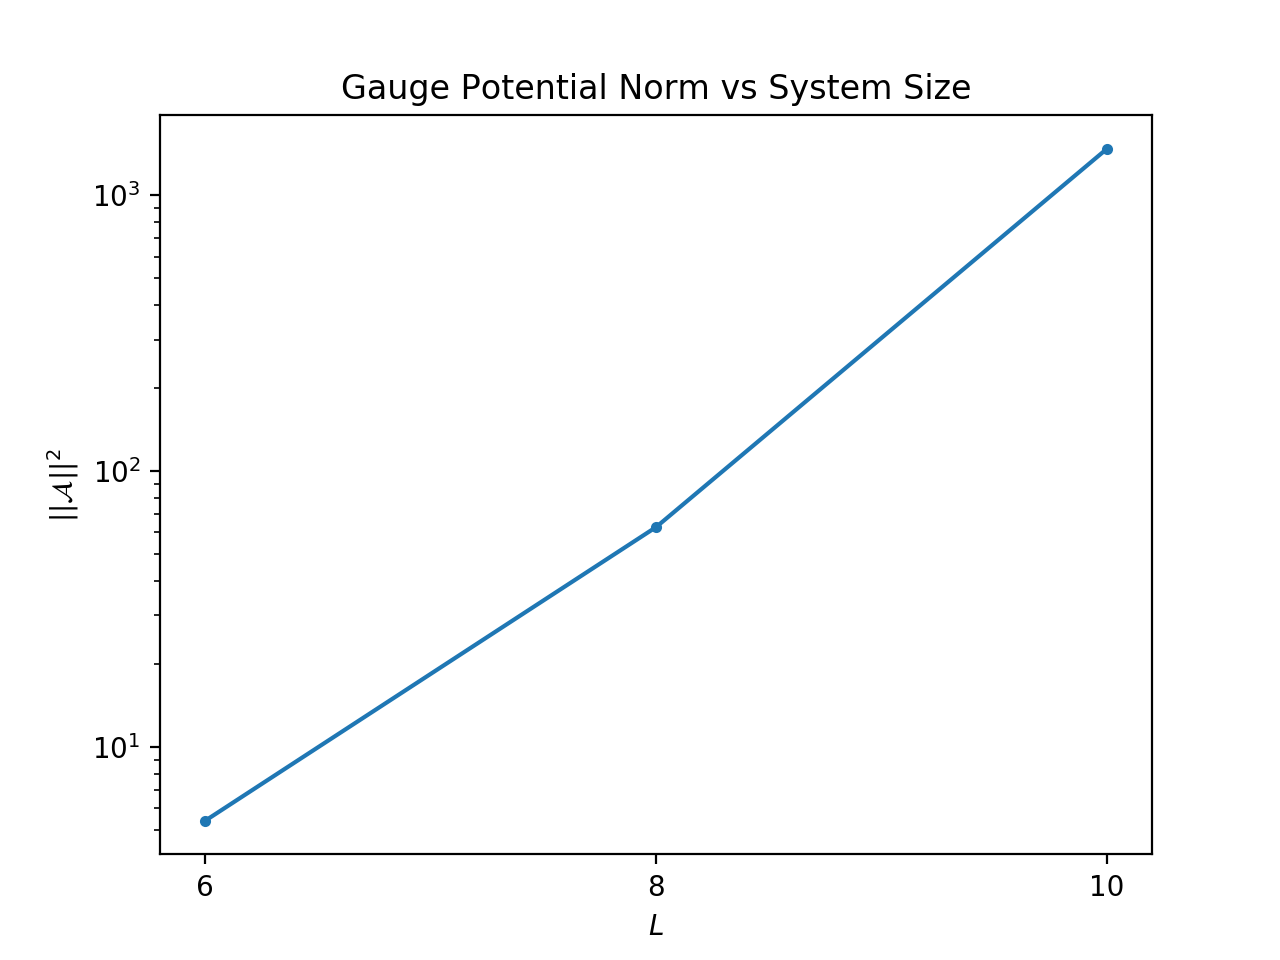

In [14]:
fig1 = plt.figure()

# Lets get the L's from the dataframe
Ls= df_g1['L']

# Lets get the A_norms's from the dataframe
Anorms= df_g1['A_norm']

# Lets plot
plt.semilogy(Ls[1::2], Anorms[1::2], '.-')
plt.xticks(L_list[1::2])
plt.title('Gauge Potential Norm vs System Size')
plt.ylabel('$|| \mathcal{A} ||^2$')
plt.xlabel('$L$')
plt.show()

Nice! A rough exponential trend appears, although to actually make a definite statement about the thermodynamic limit ($L\to\infty$) you would want to plot several larger values of $L$ - Note that this get pretty expensive with exact diagonalization by $L=16$ ( as of 2020, forget about trying $L=18$ unless you can exploit symmetries of the system or have a very good tool at hand ).

Alternatively, we could fix the system size (say $L=8$) and vary another parameter, like the anisotropy $\alpha$:

In [15]:
df_g2 = df.groupby(['g_id', 'L' ,'beta','gamma'],axis=0).get_group((0,8,1.0,0.5))
df_g2

,L,g_id,alpha,beta,gamma,E,S0z,A_norm
99,8,0,0.0,1.0,0.5,"[-4.0, -3.152095064161371, -3.15209506416137, ...","[-0.5, -0.5000000000000003, -0.170943058495785...",64.98000000000002
231,8,0,0.1,1.0,0.5,"[-4.0, -3.168622030810685, -3.135719120115508,...","[-0.5, -0.5000000000000002, -0.164695764820404...",64.4337637481755
363,8,0,0.2,1.0,0.5,"[-4.0, -3.185292662637562, -3.119503945643071,...","[-0.5, -0.5, -0.1593260453693648, -0.500000000...",63.07444108619381
495,8,0,0.3,1.0,0.5,"[-4.0, -3.202101168160894, -3.103462972503889,...","[-0.5, -0.4999999999999998, -0.155158876730534...",61.63392793817152
627,8,0,0.4,1.0,0.5,"[-4.0, -3.219042786391479, -3.087615405866007,...","[-0.5, -0.5, -0.1526640115785678, -0.500000000...",61.09542923810848
759,8,0,0.5,1.0,0.5,"[-4.0, -3.236113432321708, -3.082237623259628,...","[-0.5, -0.4999999999999999, -0.500000000000000...",62.65197786380524
891,8,0,0.6,1.0,0.5,"[-4.0, -3.253309459078686, -3.092897370109216,...","[-0.5, -0.5000000000000004, -0.500000000000000...",68.05535944437648
1023,8,0,0.7,1.0,0.5,"[-4.0, -3.270627497169038, -3.103812596467486,...","[-0.5, -0.4999999999999996, -0.500000000000000...",80.50596703519858
1155,8,0,0.8,1.0,0.5,"[-4.0, -3.288064345809164, -3.114944229824903,...","[-0.5, -0.5000000000000001, -0.499999999999999...",106.0232504460649
1287,8,0,0.9,1.0,0.5,"[-4.0, -3.305616900128084, -3.126258150149058,...","[-0.5, -0.5000000000000001, -0.500000000000000...",153.749896422397


<IPython.core.display.Javascript object>


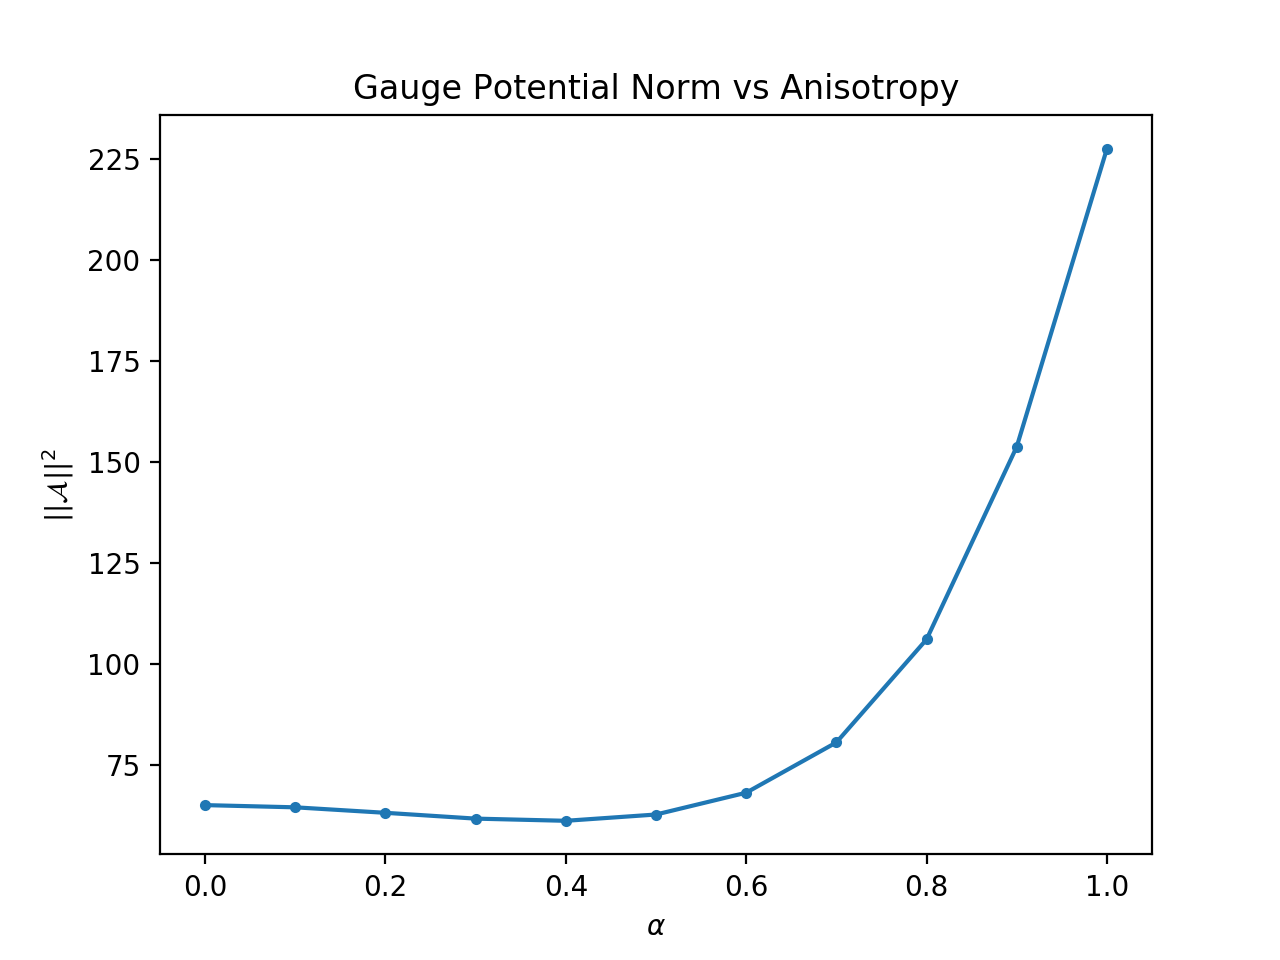

In [16]:
fig2 = plt.figure()

# Lets get the L's from the dataframe
alphas= df_g2['alpha']

# Lets get the A_norms's from the dataframe
Anorms= df_g2['A_norm']

# Lets plot
plt.plot(alphas, Anorms,'.-')

plt.title('Gauge Potential Norm vs Anisotropy')
plt.ylabel('$|| \mathcal{A} ||^2$')
plt.xlabel('$\\alpha$')

plt.show()

Ok! So it quite simple to plot columns, in your data frame, but what about entries which are themselves lists, like the energies E?

We can can also easily plot all of them against any parameter, or even transform the data to plot a derived quantity, using the [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method. 

Lets plot all the energies together vs the anisotropy parameter $\alpha$. First we will set the relevant parameters fixed, and convert the E column into a collection of columns for all the energies. The latter step can be performed smoothly using the apply method, which takes a column(s) and applies a mapping to every element - this can be anything from a mathematical operation to the extraction of elements in a list as we do here. Thus, we take the 'E' column of the data frame and apply a function (lambda), which takes every element in that column and generates a pandas [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object with the values of the energies. The collection of Series objects generated over all lists in the 'E' column itself constitutes a DataFrame object, and so we [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) it with the already existing one. The result is displayed below.




In [17]:
# fix all parameters except alpha
df_g3 = df.groupby(['g_id', 'L' ,'beta','gamma'],axis=0).get_group((0,8,1.0,0.5))

# unpack the E column into multiple series, to generate new columns
df_g3 = df_g3.merge(df_g3['E'].apply(lambda s: pd.Series({'E'+str(i):s[i] for i in range(len(s))})), left_index=True, right_index=True)

# Drop the columsn we will no longer need.
df_g3.drop(['E','L','g_id','beta','gamma', 'S0z', 'A_norm'], axis=1, inplace=True)

df_g3.head()

,alpha,E0,E1,E2,E3,E4,E5,E6,E7,E8,...,E246,E247,E248,E249,E250,E251,E252,E253,E254,E255
99,0.0,-4.0,-3.152095,-3.152095,-3.034244,-3.034244,-2.965756,-2.965756,-2.847905,-2.847905,...,2.304190,2.847905,2.847905,2.965756,2.965756,3.034244,3.034244,3.152095,3.152095,4.0
231,0.1,-4.0,-3.168622,-3.135719,-3.043014,-3.025917,-2.974083,-2.956986,-2.864281,-2.831378,...,2.304341,2.831378,2.864281,2.956986,2.974083,3.025917,3.043014,3.135719,3.168622,4.0
363,0.2,-4.0,-3.185293,-3.119504,-3.052226,-3.018015,-2.981985,-2.947774,-2.880496,-2.814707,...,2.304797,2.814707,2.880496,2.947774,2.981985,3.018015,3.052226,3.119504,3.185293,4.0
495,0.3,-4.0,-3.202101,-3.103463,-3.061858,-3.010497,-2.989503,-2.938142,-2.896537,-2.797899,...,2.305564,2.797899,2.896537,2.938142,2.989503,3.010497,3.061858,3.103463,3.202101,4.0
627,0.4,-4.0,-3.219043,-3.087615,-3.071876,-3.003304,-2.996696,-2.928124,-2.912385,-2.780957,...,2.306658,2.780957,2.912385,2.928124,2.996696,3.003304,3.071876,3.087615,3.219043,4.0


In this format, it is easy to collective plot the energies as follows:

<IPython.core.display.Javascript object>


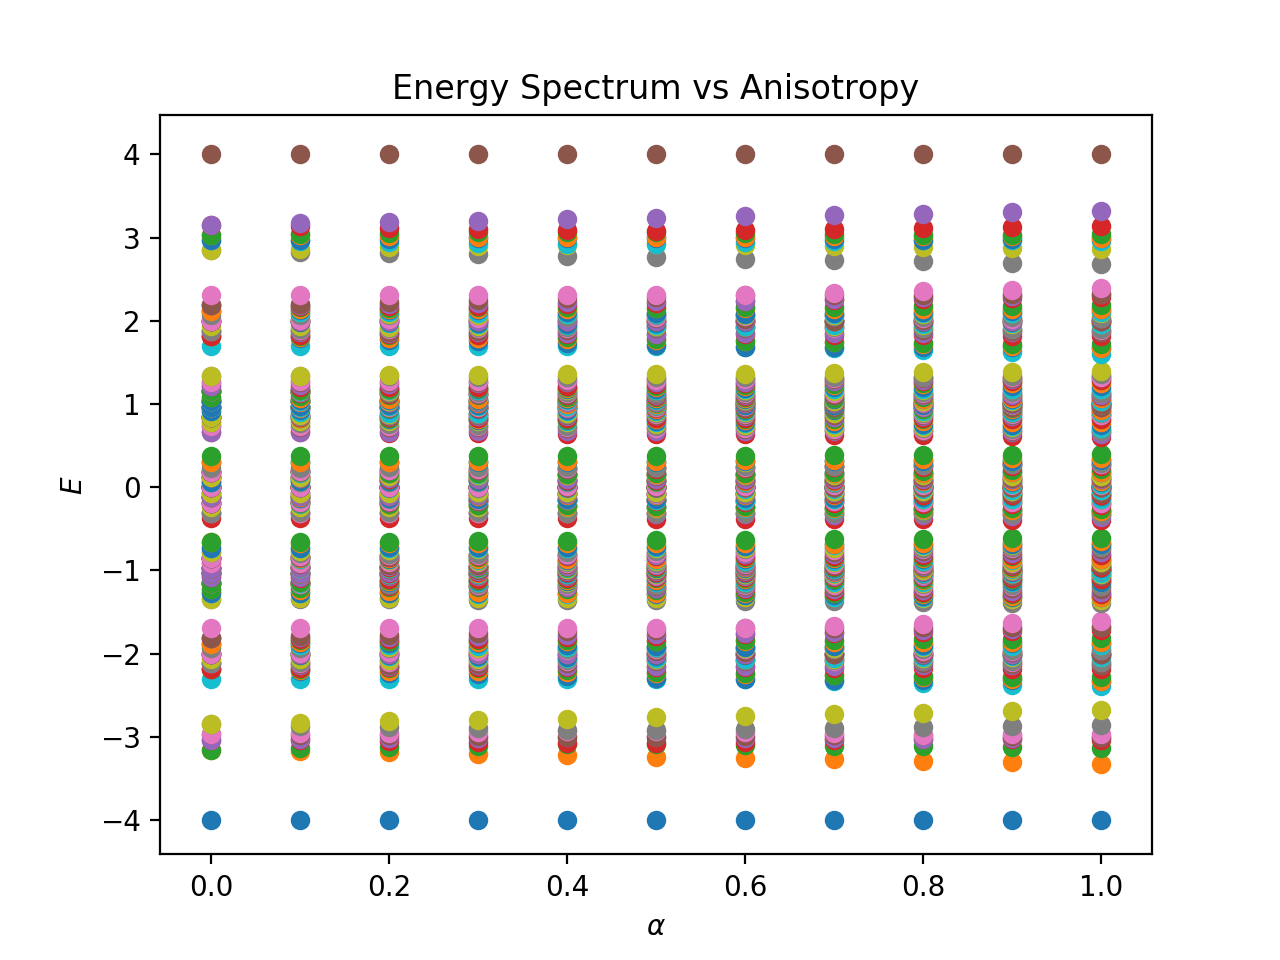

In [18]:
fig3 = plt.figure()
for col in df_g3.columns[1:]:
    plt.scatter(df_g3['alpha'],df_g3[col])
    
plt.title('Energy Spectrum vs Anisotropy')
plt.xlabel('$\\alpha$')
plt.ylabel('$E$')
plt.show()

Remarkably, the spectrum reveals various different clusterings, which upon further examination turn out to be a consequence of a special symmetry of the Hamiltonian of the XXZ model with uniform Z field, which conserves the total spin projection along the z-axis $S^z = \sum_j S^z_j$. 

### Conclusion

This brief walkthrough gives a brief introduction of what is possible using pandas data frames and plotting tools. For much more functionality, the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/) is your friend. 

Using data frames will enhance the efficiency and range of your exploratory analyses with complex physical systems. There is no need to continually re-invent the wheel everytime you probe a different combination of parameters or a new quantity. Storing and managing your data will keep you organized. Accessing and manipulating your data effectively will improve your workflow and free your mind to focus on analyzing the implications of your results and developing new insights.